# BEES vs WASP

### Seção de Bibliotecas

In [192]:
import os
from PIL import Image
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import roc_curve, auc, accuracy_score, mean_squared_error
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import pylab as pl

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

### Seção de Pré-Processamento (ETL)

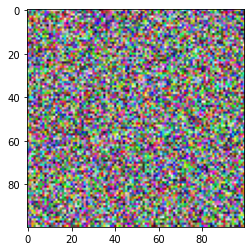

In [161]:
# Gerando dados de teste para testar 
test_data=np.random.beta(1,1,size=(100,100,3))
# exibindo teste
plt.imshow(test_data)

#### Processando Abelhas & Vespas (teste)
Uso da biblioteca PIL para carregamento e processamento de imagens

Tamanho: (320, 240)


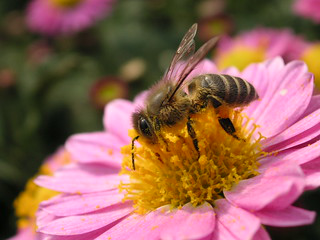

In [162]:
# Abrindo imagem de abelha para teste do dataset
img = Image.open('datasets/bee1/1240800_e5f2b40032_n.jpg')
# obtendo tamanho da imagem
img_size = img.size
print("Tamanho: {}".format(img_size))
# imprimindo
img

Tamanho: (240, 223)


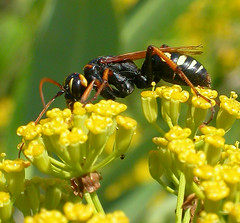

In [163]:
# Abrindo imagem de vespa para teste do dataset
img = Image.open('datasets/wasp1/30723011_68d3b0c70b_m.jpg')
# obtendo tamanho da imagem
img_size = img.size
print("Tamanho: {}".format(img_size))
# imprimindo
img

#### Manipulando as imagens
O Pillow possui uma série de tarefas comuns de manipulação de imagens incorporadas à biblioteca. Por exemplo, pode-se querer redimensionar uma imagem para que o tamanho do arquivo seja menor. Ou, talvez, converta uma imagem em preto e branco em vez de colorida. As operações que a Pillow fornece incluem:
<ul>
<li>redimensionar
<li>cortar
<li>rotação
<li>conversão para escala de cinza (ou outros modos de cor)
</ul>
Freqüentemente, esses tipos de manipulação fazem parte do pipeline para transformar um pequeno número de imagens em mais imagens para criar dados de treinamento para algoritmos de aprendizado de máquina. Essa técnica é chamada de aumento de dados e é uma técnica comum para classificação de imagens.

Vamos tentar algumas dessas operações e ver os resultados.

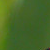

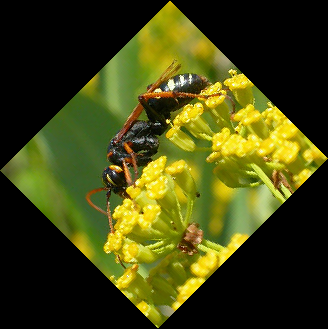

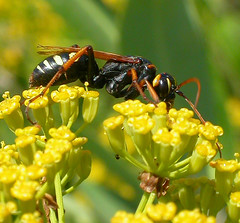

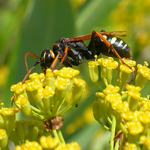

In [164]:
# cortando imagem em 25, 25, 75, 75
img_cropped = img.crop([25,25,75,75])
display(img_cropped)

# rotacionando imagem em 45 graus
img_rotated = img.rotate(45,expand=25)
display(img_rotated)

# girando imagem da esquerda para direita
img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
display(img_flipped)

# redimensionando imagem
img_resized = img.resize([150,150])
display(img_resized)

<i>Para este projeto, optamos por redimensionar toda a base de dados para um tamanho padrão de imagens para melhorar a acurácia dos nosso modelos e evitar o uso de preenchimento na nossa matriz de features.

### Imagem -> Array 
O que é uma imagem? Até agora, o PIL lidou com o carregamento e a exibição de imagens. No entanto, se vamos usar imagens como dados, precisamos entender a aparência desses dados. Para isto, nosso primeiro passo será de 'transformar' estes dados em um array e redimensionar as imagens para um tamanho padronizado 100x100. Isso significa que os dados subjacentes são uma matriz com dimensões 150x150x3.

In [165]:
def get_image(row_id, root="datasets/"):
    """
        Abre a imagem e retorna a imagem como uma matriz numpy.
    """
    filename = row_id.replace("\\", "/")
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    # redimensionando as imagens image 
    img = img.resize([100,100])
    return np.array(img)

### Análise Exploratória - Canais de Cores
A maioria dos formatos de imagem tem três "canais" de cores: vermelho, verde e azul (algumas imagens também têm um quarto canal chamado "alfa" que controla a transparência). Para cada pixel em uma imagem, existe um valor para cada canal.

<ul> -> Cores RGB</ul>

A forma como isso é representado como dados é como uma matriz tridimensional. A largura da matriz é a largura da imagem, a altura da matriz é a altura da imagem e a profundidade da matriz é o número de canais. 

Our NumPy array has the shape: (223, 240, 3)


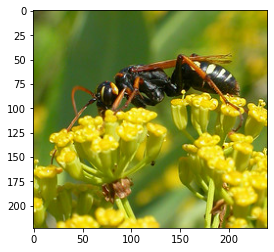

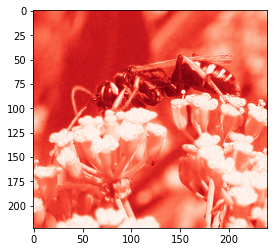

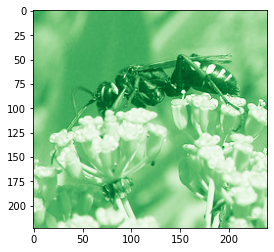

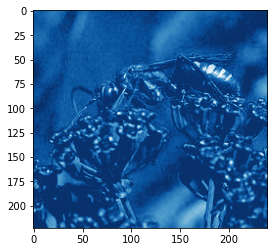

In [166]:
# Turn our image object into a NumPy array
img_data = np.array(img)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow` 
plt.imshow(img_data)
plt.show()

# plot the red channel
plt.imshow(img_data[:,:,0], cmap=plt.cm.Reds_r)
plt.show()

# plot the green channel
plt.imshow(img_data[:,:,1], cmap=plt.cm.Greens_r)
plt.show()

# plot the blue channel
plt.imshow(img_data[:,:,2], cmap=plt.cm.Blues_r)
plt.show()

Os canais de cores podem ajudar a fornecer mais informações sobre uma imagem. A imagem do oceano será mais azul, enquanto a imagem de um campo será mais verde. Esse tipo de informação pode ser útil ao construir modelos ou examinar as diferenças entre as imagens.

Veremos a estimativa de densidade do kernel para cada um dos canais de cor no mesmo gráfico para que possamos entender como eles diferem.

Quando fizermos esse gráfico, veremos que uma forma que aparece mais à direita significa mais dessa cor, enquanto mais à esquerda significa menos dessa cor.

A função abaixo está plotando uma estimativa de densidade do kernel para os dados fornecidos. O canal deve ser uma matriz 2d e as cores devem ser uma string de cor, por exemplo 'r', 'g' ou 'b'

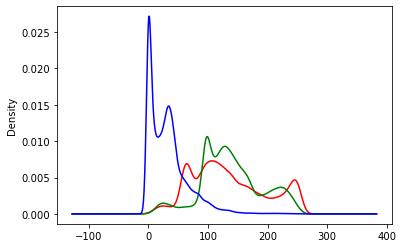

In [167]:
def plot_kde(channel, color):
    data = channel.flatten()
    return pd.Series(data).plot.density(c=color)

# criando lista de canais
channels = ['r','g','b']
    
def plot_rgb(image_data):
    # usando laço para percorrer cores e índices
    for ix, color in enumerate(channels):
       plot_kde(img_data[:,:,ix],color)

    plt.show()
    
plot_rgb(img_data)

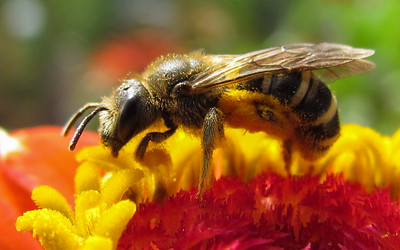

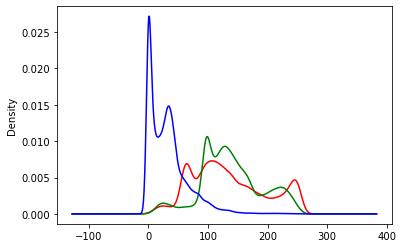

In [168]:
# Carregando imagem de abelha
honey=Image.open('datasets/bee1/19861667933_3af6691cc8_w.jpg')

# exibindo abelha
display(honey)

# NumPy array da abelha
honey_data=np.array(honey)

# plotando densidades da imagem da abelha
plot_rgb(honey_data)

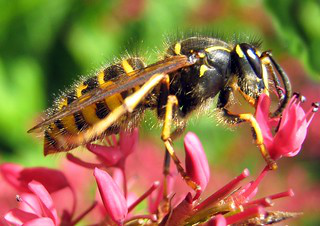

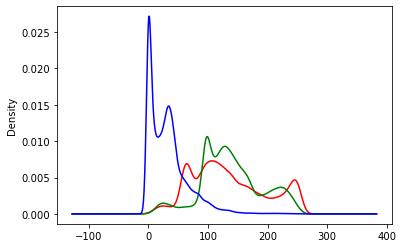

In [169]:
# Carregando uma vespa para visualizar canais 
wasp=Image.open('datasets/wasp1/12102448655_7c515869d4_n.jpg')

# exibindo imagem
display(wasp)

# NumPy array da imagem da vespa
wasp_data=np.array(wasp)

# imprimindo gráfico de densidades da imagem
plot_rgb(wasp_data)

In [170]:
def create_features(img):
    # achatando imagem em 3 canais de cores
    color_features = img.flatten()
    # convertendo imagem para escala preto/branco
    gray_image = rgb2gray(img)
    # HOG features da imagem em cinza
    hog_features = hog(gray_image, block_norm='L2-Hys',
                       pixels_per_cell=(16, 16))
    # ccombinando cor hog e imagem cinza em único vetor
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

### RGB -> GRAY

Embora às vezes as informações sobre cores sejam úteis, outras vezes podem ser uma distração. Nestes exemplos em que observamos as abelhas, as próprias abelhas têm cores muito semelhantes. Por outro lado, as abelhas costumam ficar em cima de flores de cores diferentes. Sabemos que as cores das flores podem atrapalhar a separação das abelhas melíferas, então vamos converter essas imagens em preto e branco, ou "escala de cinza".

A escala de cinza é apenas um dos modos compatíveis com o Pillow. A alternância entre os modos é feita com o método .convert (), que recebe uma string para o novo modo.

Como mudamos o número de "canais" de cores, a forma de nossa matriz muda com essa mudança. Também será interessante observar como o KDE da versão em tons de cinza se compara à versão RGB acima.

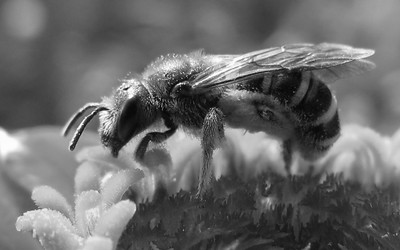

Our NumPy array has the shape: (250, 400)


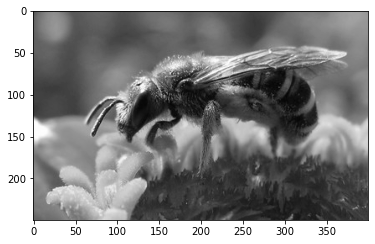

<AxesSubplot:ylabel='Density'>

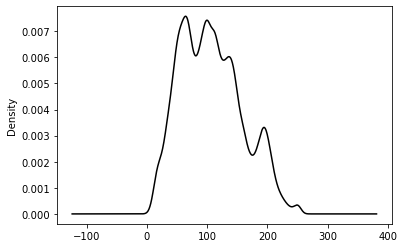

In [171]:
# EXEMPLO DE CONVERSÃO RGB -> GRAY
honey_bw = honey.convert("L")
display(honey_bw)

honey_bw_arr = np.array(honey_bw)

honey_bw_arr_shape = honey_bw_arr.shape
print("Our NumPy array has the shape: {}".format(honey_bw_arr_shape))

plt.imshow(honey_bw_arr, cmap=plt.cm.gray)
plt.show()

plot_kde(honey_bw_arr, 'k')

### HOG - Histograma Orientado à Gradiente

Agora precisamos transformar essas imagens em algo que um algoritmo de aprendizado de máquina possa entender. As técnicas tradicionais de visão por computador se baseiam em transformações matemáticas para transformar imagens em recursos úteis. Por exemplo, você pode querer detectar bordas de objetos em uma imagem, aumentar o contraste ou filtrar cores específicas.

Temos uma matriz de valores de pixel, mas eles não contêm informações interessantes suficientes por conta própria para a maioria dos algoritmos. Precisamos ajudar os algoritmos escolhendo algumas das características salientes para eles usando o descritor de histograma de gradientes orientados (HOG). A ideia por trás do HOG é que a forma de um objeto dentro de uma imagem pode ser inferida por suas bordas, e uma maneira de identificar as bordas é olhando para a direção dos gradientes de intensidade (ou seja, mudanças na luminescência).

Uma imagem é dividida em forma de grade em células e, para os pixels dentro de cada célula, um histograma de direções de gradiente é compilado. Para melhorar a invariância de realces e sombras em uma imagem, as células são normalizadas em bloco, o que significa que um valor de intensidade é calculado para uma região maior de uma imagem chamada de bloco e usado para normalizar o contraste de todos os histogramas de nível de célula em cada bloco. O vetor de recursos HOG para a imagem é a concatenação desses histogramas em nível de célula.

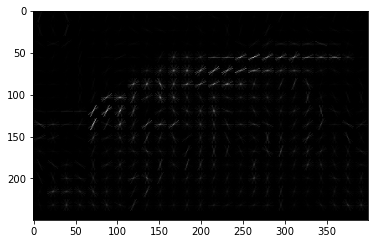

In [172]:
# EXEMPLO DE TRANSFORMAÇÃO EM HOG
hog_features, hog_image = hog(honey_bw_arr,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# exibindo imagem em HOG utilizando cmap
plt.imshow(hog_image, cmap=mpl.cm.gray)

### Loop de Pré-Processamento
Geramos uma matriz de recursos achatada para a imagem bombus. Agora é hora de fazer um loop em todas as nossas imagens. Vamos criar recursos para cada imagem e, em seguida, empilhar os arrays de recursos achatados em uma grande matriz que podemos passar para nosso modelo.

Na função create_feature_matrix, faremos o seguinte:
<ul>
<li>Carregar uma imagem;
<li>Gerar uma linha de recursos usando a função create_features acima;
<li>Empilhar as linhas em uma matriz de recursos;
<li>Na matriz de recursos resultante, as linhas correspondem a imagens e as colunas a recursos.

In [173]:
def create_feature_matrix(label_dataframe, total_dados):
    features_list = []
    # contadores de limite de dados
    total_bees = 0
    total_wasp = 0

    for _, row in label_dataframe.iterrows():
        # só considera casos onde é vespa ou abelha e com qualidade de foto boa
        if ((row.is_wasp == 1 and total_wasp < total_dados) or (row.is_bee == 1 and total_bees < total_dados)) and row.photo_quality == 1:
            if row.is_wasp == 1:
                total_wasp = total_wasp + 1
            else:
                total_bees = total_bees + 1

            # carrega imagem
            img = get_image(row.path)
            # features da imagens
            image_features = create_features(img)
            features_list.append(image_features)

    # converte lista de vetories na matriz
    feature_matrix = np.zeros([len(features_list), len(
        max(features_list, key=lambda x: len(x)))])
    for i, j in enumerate(features_list):
        feature_matrix[i][0:len(j)] = j

    return feature_matrix

### Matriz de Features Escalável + PCA

Nossos recursos ainda não estão prontos. Muitos métodos de aprendizado de máquina são desenvolvidos para funcionar melhor com dados que têm média 0 e variação de unidade. Felizmente, o scikit-learn oferece uma maneira simples de redimensionar seus dados para funcionar bem com o StandardScaler. Eles têm uma explicação mais completa do motivo disso nos documentos vinculados.

Precisamos reduzir o número de recursos que temos usando a análise de componente principal (PCA).

O <b>PCA</b> é uma maneira de transformar linearmente os dados de forma que a maioria das informações nos dados esteja contida em um número menor de recursos chamados de componentes. Abaixo está um exemplo visual de um conjunto de dados de imagens contendo números escritos à mão. A imagem à esquerda é a imagem original com 784 componentes. Podemos ver que a imagem à direita (pós PCA) captura a forma do número de forma bastante eficaz, mesmo com apenas 59 componentes.

Em nosso projeto, mantemos apenas 500 componentes. Isso significa que nossa matriz de recursos terá apenas 500 colunas em vez das 31.296 originais.

In [174]:
def load_bvsw(total_dados=50):
    print("Abrindo arquivo...")
    labels = pd.read_csv("datasets/labels.csv", index_col=0)

    # verifica limite de dados
    if total_dados > 4000:
        total_dados = 4000

    total_dados = total_dados // 2

    print("Criando matriz de features...")
    feature_matrix = create_feature_matrix(labels, total_dados)

    # define standard scaler
    ss = StandardScaler()
    # roda na nossa matriz de features 
    print("Padronizando dados...")
    bees_stand = ss.fit_transform(feature_matrix)

    pca = PCA(n_components=min(500, total_dados*2))
    # usando fit_transform para o PCA na nossa matriz 
    print("Rodando PCA (esse processo pode demorar um pouco)...")
    bees_pca = pca.fit_transform(bees_stand)
    # verificando nossas novas dimensões
    print('Matriz de PCA concluída com formato: ', bees_pca.shape)

    classes = np.concatenate((np.ones(total_dados), np.zeros(total_dados)))

    return bees_pca, classes

### Seção de Modelos de Classificação e Métodos de Validação

<b>Modelos:</b>
<ol>
<li>SVM;
<li>Naive Bayes;
<li>Árvore de decisão.
</ol>
    
<b>Validação:</b>
<ol>
<li>Holdout repetido;
<li>KFold.
</ol>

In [175]:
def escolhe_modelo(escolha):
    if escolha == '1':
        return SVC(kernel='linear', probability=True, random_state=42)
    elif escolha == '2':
        return GaussianNB()
    elif escolha == '3':
        return DecisionTreeClassifier(random_state=42)
    else:
        print("Opção não existe! Terminando...")
        exit()

In [176]:
escolha = '1' #modelo
validacao = '1' # validação

<i> Definimos também a quantidade de imagens que serão usadas para classificação e quantidade de repetições do método de validação

In [177]:
quantidade_dados = 500  # máximo é 4000
repeticoes = 10 

<i> Agora, os dados são carregados.

In [178]:
entrada, saida = load_bvsw(quantidade_dados)

Abrindo arquivo...
Criando matriz de features...
Padronizando dados...
Rodando PCA (esse processo pode demorar um pouco)...
Matriz de PCA concluída com formato:  (500, 500)


In [193]:
# para uso da validacao
acertos = []
aucs = []
mses = []
# pra plot de melhor roc
falsos_positivos = []
verdadeiros_positivos = []

if validacao == '1':
    kf = KFold(n_splits=repeticoes, shuffle=True)

    for treino, teste in kf.split(entrada, saida):
        # redefine modelo a cada repeticao
        modelo = escolhe_modelo(escolha)

        # fit model
        modelo.fit(entrada[treino], saida[treino])

        # gerando prediçóes
        predicao = modelo.predict(entrada[teste])

        # calculando acurácia do modelo
        acerto = accuracy_score(predicao, saida[teste])
        # prediz probabilidadess para entrada[teste] utilizando predict_proba
        probabilities = modelo.predict_proba(entrada[teste])
        # seleciona probabilidades para os rótulos 1.0
        saida_proba = probabilities[:, 1]
        # calcula a taxa de falso positivo e taxa de verdadeiro positivo em diferentes limites
        false_positive_rate, true_positive_rate, _ = roc_curve(
            saida[teste], saida_proba, pos_label=1)

        # calcula a curva AUC
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # MSE
        mse = mean_squared_error(saida[teste], predicao)

        # guarda resultados
        acertos.append(acerto)
        aucs.append(roc_auc)
        mses.append(mse)
        falsos_positivos.append(false_positive_rate)
        verdadeiros_positivos.append(true_positive_rate)

else:
    # divide em sets de treino e teste
    entrada_treino, entrada_teste, saida_treino, saida_teste = train_test_split(entrada,
                                                                                saida,
                                                                                test_size=.3,
                                                                                random_state=1234123)

    # holdout repetido
    for _ in range(repeticoes):
        # redefine modelo a cada repeticao
        modelo = escolhe_modelo(escolha)

        # fit model
        modelo.fit(entrada_treino, saida_treino)

        # generate predições
        predicao = modelo.predict(entrada_teste)

        # calculate accurácia
        acerto = accuracy_score(predicao, saida_teste)
        # prediz probabilidadess para entrada_teste utilizando predict_proba
        probabilities = modelo.predict_proba(entrada_teste)
        #  seleciona probabilidades para os rótulos 1.0
        saida_proba = probabilities[:, 1]
        # calcula taxa de falso positivo e taxa de verdadeiro positivo em diferentes limites
        false_positive_rate, true_positive_rate, _ = roc_curve(
            saida_teste, saida_proba, pos_label=1)

        # calcula curva AUC
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # MSE
        mse = mean_squared_error(saida_teste, predicao)

        # guarda resultados
        acertos.append(acerto)
        aucs.append(roc_auc)
        mses.append(mse)
        falsos_positivos.append(false_positive_rate)
        verdadeiros_positivos.append(true_positive_rate)

In [185]:
print("Resultados:\n")
print(f"Acerto médio: {np.average(acertos)} (+-{np.std(acertos)})")
print(f"AUC médio: {np.average(aucs)} (+-{np.std(aucs)})")
print(f"MSE médio: {np.average(mses)} (+-{np.std(mses)})")
melhor_rodada = np.argmax(acertos)
print("Melhor rodada: ", melhor_rodada)

Resultados:

Acerto médio: 0.632 (+-0.05455272678794342)
AUC médio: 0.672434021772683 (+-0.06303133063444318)
MSE médio: 0.368 (+-0.05455272678794343)
Melhor rodada:  7


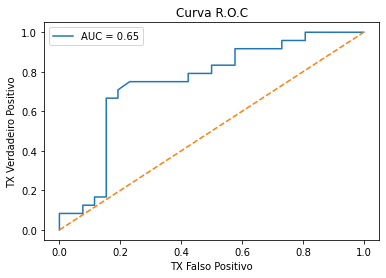

In [186]:
plt.title('Curva R.O.C')
# plota a taxa de falsos positivos no eixo xe a taxa de verdadeiros positivos no eixo y
plt.plot(falsos_positivos[melhor_rodada],
         verdadeiros_positivos[melhor_rodada],
         label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0, 1], [0, 1], ls='--')
plt.ylabel('TX Verdadeiro Positivo')
plt.xlabel('TX Falso Positivo')
plt.show()